In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from shapely.geometry import Polygon
import difflib
import glob
import os
from pathlib import Path
import xarray as xr

from netCDF4 import Dataset

# NB THE ERA5 AND CHIRPS DATA GO IN REVERSE ORDER 

print(CHIPRS_dataset['latitude'][:])
[-17.125    -17.075    -17.025002...

print(era5_data['latitude'][:]) [ -9.376  -9.626  -9.876 -10.126 



# Load CHIRPS

In [66]:
chirps_xr = xr.open_dataset('/Users/rem76/Desktop/Climate_change_health/Data/CHIRPS/java_chirps-v2.0.monthly_malawi_clipped.nc')
chirps_xr = chirps_xr.where(
    chirps_xr['time.year'] > 2010, drop=True)

In [67]:
chirps_xr_coarse = chirps_xr.coarsen(latitude = 5, boundary="trim").mean()
chirps_xr_coarse.coarsen(longitude = 5, boundary="trim").mean()


<xarray.Dataset> Size: 269kB
Dimensions:    (time: 166, latitude: 31, longitude: 13)
Coordinates:
  * time       (time) datetime64[ns] 1kB 2011-01-01 2011-02-01 ... 2024-10-01
  * longitude  (longitude) float32 52B 32.77 33.02 33.27 ... 35.27 35.52 35.77
  * latitude   (latitude) float32 124B -17.02 -16.77 -16.52 ... -9.775 -9.525
Data variables:
    precip     (time, latitude, longitude) float32 268kB 343.8 419.2 ... 29.62
Attributes: (12/17)
    CDI:               Climate Data Interface version 2.4.4 (https://mpimet.m...
    Conventions:       CF-1.6
    institution:       Climate Hazards Group.  University of California at Sa...
    title:             CHIRPS Version 2.0
    history:           Thu Nov 21 13:55:19 2024: cdo sellonlatbox,32.67161823...
    version:           Version 2.0
    ...                ...
    comments:           time variable denotes the first day of the given month.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ
    CDO:               Climate Data Operators version 2.4.4 (https://mpimet.m...

# Load ERA5 

In [68]:
era5_data_xr = xr.open_dataset('/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Historical/monthly_data/724bab97773bb7ba4e1635356ad0d12.nc')

# Load TAMSAT

In [69]:
tamsat_xr = xr.open_dataset('/Users/rem76/Desktop/Climate_change_health/Data/TAMSAT/rfe1983-present_monthly_0.25.v3.1.nc')


In [70]:

tamsat_xr_filtered = tamsat_xr.where(
    (tamsat_xr['time.year'] > 2009) &
    (tamsat_xr['lat'] >= -17.12627881) & (tamsat_xr['lat'] <= -9.36366167) &
    (tamsat_xr['lon'] >= 32.67161823) & (tamsat_xr['lon'] <= 35.91841716),
    drop=True
)


# NB - ERA5 
The hydrological parameters have effective units of "m of water per day" and so they should be multiplied by 1000 to convert to kgm-2day-1 or mmday-1.

https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Monthlymeans 

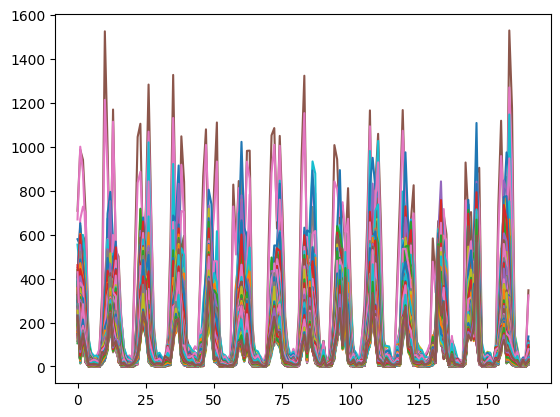

In [71]:
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month = 0
for i in range(len(era5_data_xr['latitude'][:])):
    for j in range(len(era5_data_xr['longitude'][:])):
        pr_data_time_series_grid = era5_data_xr['tp'][:, i, j]
        pr_data_time_series_grid *= 1000 * days_in_month[month] # to get to mm
        plt.plot(pr_data_time_series_grid)
        month = (month + 1) % 12

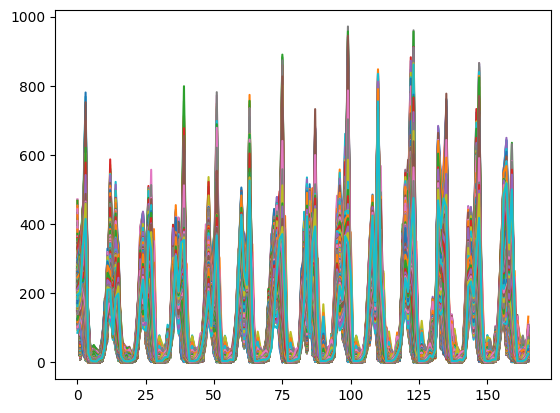

In [72]:
for i in range(len(chirps_xr['latitude'][:])):
    for j in range(len(chirps_xr['longitude'][:])):
        pr_data_time_series_grid = chirps_xr['precip'][:, i, j]
        plt.plot(pr_data_time_series_grid)

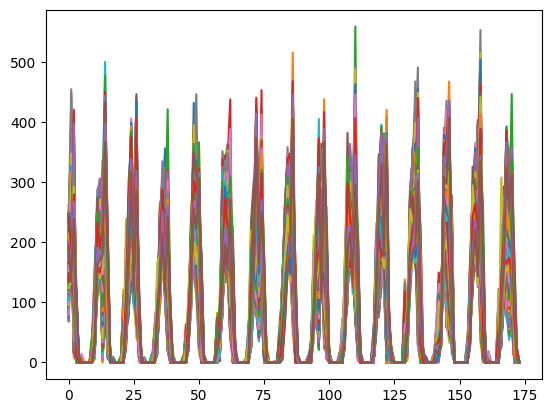

In [73]:
for i in range(len(tamsat_xr_filtered['lat'][:])):
    for j in range(len(tamsat_xr_filtered['lon'][:])):
        pr_data_time_series_grid = tamsat_xr_filtered['rfe_filled'][:, i, j]
        plt.plot(pr_data_time_series_grid)

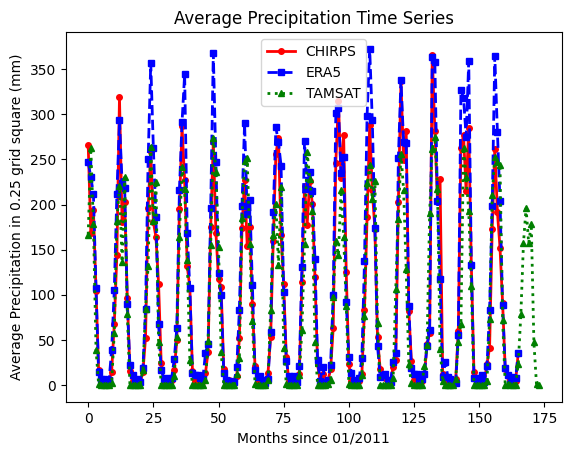

In [74]:
pr_data_time_series_avg_CHIRPS = chirps_xr['precip'].mean(dim=['latitude', 'longitude'])
pr_data_time_series_avg_ERA5 = era5_data_xr['tp'].mean(dim=['latitude', 'longitude'])
pr_data_time_series_avg_tamsat = tamsat_xr_filtered['rfe_filled'].mean(dim=['lat', 'lon'])

# Plot the averaged precipitation time series with distinct styles
plt.plot(pr_data_time_series_avg_CHIRPS, color="red", linewidth=2, linestyle='-', marker='o', markersize=4, label='CHIRPS')
plt.plot(pr_data_time_series_avg_ERA5 * 1000 * 30, color="blue", linewidth=2, linestyle='--', marker='s', markersize=4, label='ERA5')
plt.plot(pr_data_time_series_avg_tamsat, color="green", linewidth=2, linestyle=':', marker='^', markersize=4, label='TAMSAT')

plt.xlabel('Months since 01/2011')
plt.ylabel('Average Precipitation in 0.25 grid square (mm)')
plt.title('Average Precipitation Time Series')
plt.legend()
plt.show()

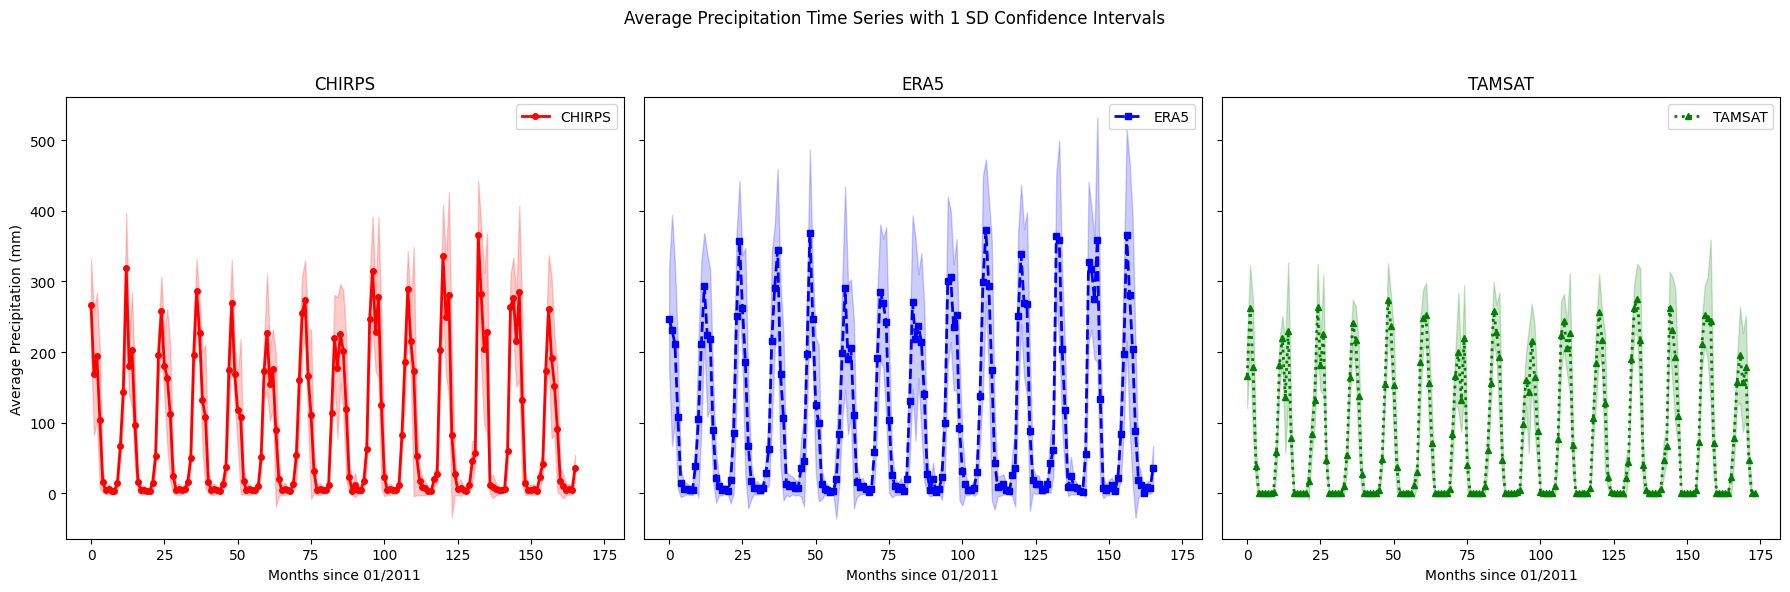

In [12]:
pr_data_time_series_avg_CHIRPS = chirps_xr['precip'].mean(dim=['latitude', 'longitude'])
pr_data_time_series_sd_CHIRPS = chirps_xr['precip'].std(dim=['latitude', 'longitude'])

pr_data_time_series_avg_ERA5 = era5_data_xr['tp'].mean(dim=['latitude', 'longitude'])
pr_data_time_series_sd_ERA5 = era5_data_xr['tp'].std(dim=['latitude', 'longitude'])

pr_data_time_series_avg_tamsat = tamsat_xr_filtered['rfe_filled'].mean(dim=['lat', 'lon'])
pr_data_time_series_sd_tamsat = tamsat_xr_filtered['rfe_filled'].std(dim=['lat', 'lon'])

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].plot(pr_data_time_series_avg_CHIRPS, color="red", linewidth=2, linestyle='-', marker='o', markersize=4, label='CHIRPS')
axs[0].fill_between(range(len(pr_data_time_series_avg_CHIRPS)), 
                    pr_data_time_series_avg_CHIRPS - pr_data_time_series_sd_CHIRPS, 
                    pr_data_time_series_avg_CHIRPS + pr_data_time_series_sd_CHIRPS, 
                    color="red", alpha=0.2)
axs[0].set_title('CHIRPS')
axs[0].set_xlabel('Months since 01/2011')
axs[0].set_ylabel('Average Precipitation (mm)')

axs[1].plot(pr_data_time_series_avg_ERA5 * 1000 * 30, color="blue", linewidth=2, linestyle='--', marker='s', markersize=4, label='ERA5')
axs[1].fill_between(range(len(pr_data_time_series_avg_ERA5)), 
                    (pr_data_time_series_avg_ERA5 - pr_data_time_series_sd_ERA5) * 1000 * 30, 
                    (pr_data_time_series_avg_ERA5 + pr_data_time_series_sd_ERA5) * 1000 * 30, 
                    color="blue", alpha=0.2)
axs[1].set_title('ERA5')
axs[1].set_xlabel('Months since 01/2011')

axs[2].plot(pr_data_time_series_avg_tamsat, color="green", linewidth=2, linestyle=':', marker='^', markersize=4, label='TAMSAT')
axs[2].fill_between(range(len(pr_data_time_series_avg_tamsat)), 
                    pr_data_time_series_avg_tamsat - pr_data_time_series_sd_tamsat, 
                    pr_data_time_series_avg_tamsat + pr_data_time_series_sd_tamsat, 
                    color="green", alpha=0.2)
axs[2].set_title('TAMSAT')
axs[2].set_xlabel('Months since 01/2011')

for ax in axs:
    ax.legend()

plt.suptitle('Average Precipitation Time Series with 1 SD Confidence Intervals')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# try on a map 

In [13]:
-9.375
-17.125
35.875
32.675003

32.675003

{30.0: ([<matplotlib.lines.Line2D at 0x14b8a1850>],
  [Text(667.1692457080871, -19920.892788966048, '30°E')]),
 30.25: ([<matplotlib.lines.Line2D at 0x14b817e50>],
  [Text(28021.10831973966, -19920.892788966048, '30.25°E')]),
 30.5: ([<matplotlib.lines.Line2D at 0x14b878cd0>],
  [Text(56042.21663947932, -19920.892788966048, '30.5°E')]),
 30.75: ([<matplotlib.lines.Line2D at 0x14e7cd4d0>],
  [Text(84063.32495921898, -19920.892788966048, '30.75°E')]),
 31.0: ([<matplotlib.lines.Line2D at 0x14e9dbd10>],
  [Text(111417.26403325055, -19920.892788966048, '31°E')]),
 31.25: ([<matplotlib.lines.Line2D at 0x14b63eb10>],
  [Text(139438.3723529902, -19920.892788966048, '31.25°E')]),
 31.5: ([<matplotlib.lines.Line2D at 0x14b63eed0>],
  [Text(167459.48067272987, -19920.892788966048, '31.5°E')]),
 31.75: ([<matplotlib.lines.Line2D at 0x14b63c550>],
  [Text(194813.41974676144, -19920.892788966048, '31.75°E')]),
 32.0: ([<matplotlib.lines.Line2D at 0x14e7cddd0>],
  [Text(222834.5280665011, -19920.892

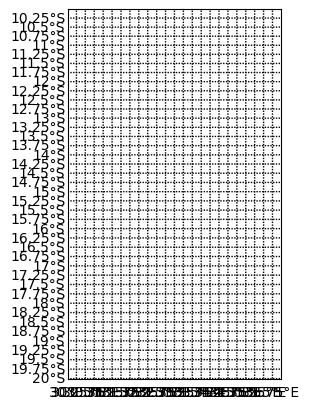

In [14]:
from mpl_toolkits.basemap import Basemap
map = Basemap(projection='merc',llcrnrlon=30.,llcrnrlat=-20.,urcrnrlon=36.,urcrnrlat=-10.,resolution='i') # projection, lat/lon extents and resolution of polygons to draw, Malawi 
meridians = np.arange(30,36,0.25) # make longitude lines ever 5 degrees from 30N-50N
parallels = np.arange(-20,-10,0.25) # make latitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

# Try a grid-by-grid, month-by-month comparison of weather

In [17]:
chirps_xr_coarse_lat_flipped = chirps_xr_coarse.sel(latitude=slice(None, None, -1)) # was in ascending order

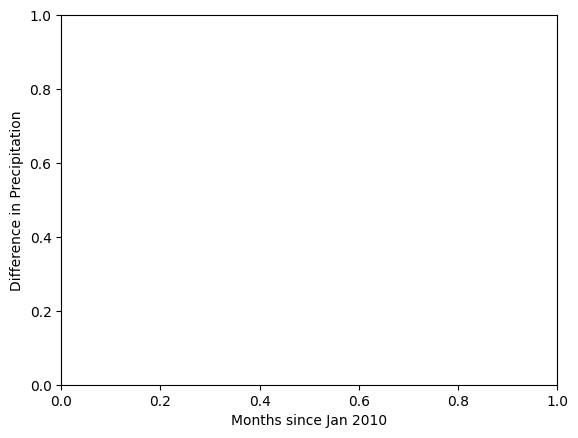

In [36]:

#for m in range(len(era5_data_xr['date'])):
diff_CHIRPS_all = {}
diff_TAMSAT_all = {}
diff_CHIRPS_TAMSAT_all = {}
for m in range(len(era5_data_xr['date'])):
    diff_CHIRPS = []
    diff_TAMSAT = []
    diff_CHIRPS_TAMSAT = []
    month = 0
    for i in range(len(era5_data_xr['latitude']) - 1):
        for j in range(len(era5_data_xr['longitude'])):
            weather_era5 = era5_data_xr['tp'][m, i, j] * 1000 * days_in_month[month]
            weather_CHIRPS = chirps_xr_coarse_lat_flipped['precip'][m, i, j]
            weather_TAMSAT = tamsat_xr_filtered['rfe_filled'][m, i, j]

            diff_CHIRPS.append(weather_era5 - weather_CHIRPS)
            diff_TAMSAT.append(weather_era5 - weather_TAMSAT)
            diff_CHIRPS_TAMSAT.append(weather_CHIRPS - weather_TAMSAT)
            # plt.plot(diff_CHIRPS, label='ERA5 - CHIRPS', color='green',alpha=0.2)
            # plt.plot(diff_TAMSAT, label='ERA5 - TAMSAT', color='purple', alpha=0.2)
            # plt.plot(diff_CHIRPS_TAMSAT, label='CHIRPS - TAMSAT', color='red',alpha=0.2)
        diff_CHIRPS_all[m] = np.mean(diff_CHIRPS)
        diff_TAMSAT_all[m] = np.mean(diff_TAMSAT)
        diff_CHIRPS_TAMSAT_all[m] = np.mean(diff_CHIRPS_TAMSAT)
        month = (month + 1) % 12

                
plt.xlabel("Months since Jan 2010")
plt.ylabel("Difference in Precipitation")
plt.show()
            

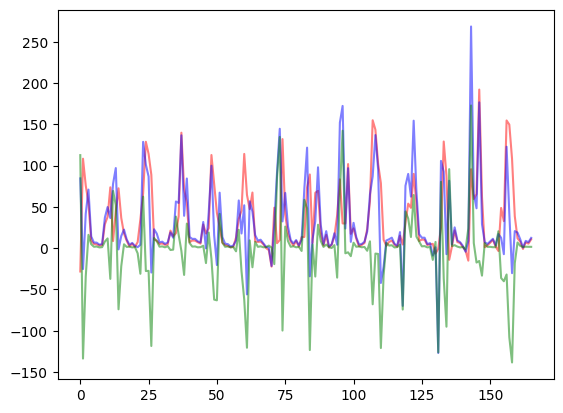

In [41]:
plt.plot(diff_CHIRPS_all.keys(), diff_CHIRPS_all.values(), color = "red", label = "ERA5 - CHIRPS", alpha = 0.5)
plt.plot(diff_TAMSAT_all.keys(), diff_TAMSAT_all.values(), color = "blue", label = "ERA5 - TAMSAT", alpha = 0.5)
plt.plot(diff_CHIRPS_TAMSAT_all.keys(), diff_CHIRPS_TAMSAT_all.values(), color = "green", label = "ERA5 - TAMSAT", alpha = 0.5)


Detrend

In [61]:
from scipy.signal import detrend

detrended_diff_CHIRPS_all = {}
detrended_diff_TAMSAT_all = {}
detrended_diff_ERA5_all = {}

detrended_diff_CHIRPS = []
detrended_diff_TAMSAT = []
detrended_diff_ERA5 = []

grid = 0
for i in range(len(era5_data_xr['latitude']) - 1):
        for j in range(len(era5_data_xr['longitude'])):
            weather_era5_series = era5_data_xr['tp'][:, i, j].values * 1000 * 365
            weather_CHIRPS_series = chirps_xr_coarse_lat_flipped['precip'][:, i, j].values
            weather_TAMSAT_series = tamsat_xr_filtered['rfe_filled'][:, i, j].values

            detrended_weather_era5 = detrend(weather_era5_series)
            detrended_weather_CHIRPS = detrend(weather_CHIRPS_series)
            detrended_weather_TAMSAT = detrend(weather_TAMSAT_series)

            detrended_diff_CHIRPS.append(detrended_weather_CHIRPS)
            detrended_diff_TAMSAT.append(detrended_weather_TAMSAT)
            detrended_diff_ERA5.append(detrended_weather_era5)
    
        detrended_diff_CHIRPS_all[grid] = detrended_diff_CHIRPS
        detrended_diff_TAMSAT_all[grid] = detrended_diff_TAMSAT
        detrended_diff_ERA5_all[grid] = detrended_diff_ERA5
        grid +=1



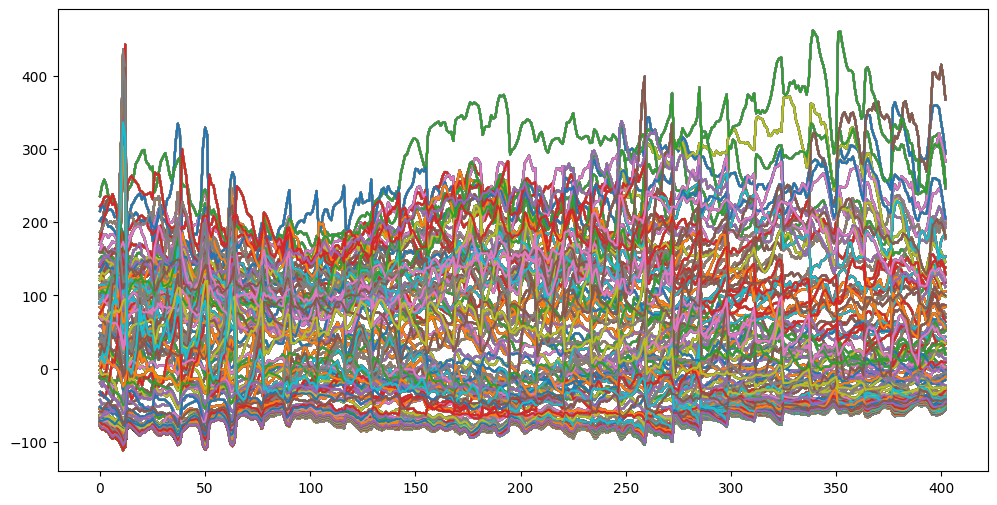

In [62]:
plt.figure(figsize=(12, 6))
for grid in detrended_diff_CHIRPS_all.keys():
    
    plt.plot(range(len(detrended_diff_CHIRPS_all[grid])), detrended_diff_CHIRPS_all[grid], label="Detrended CHIRPS")

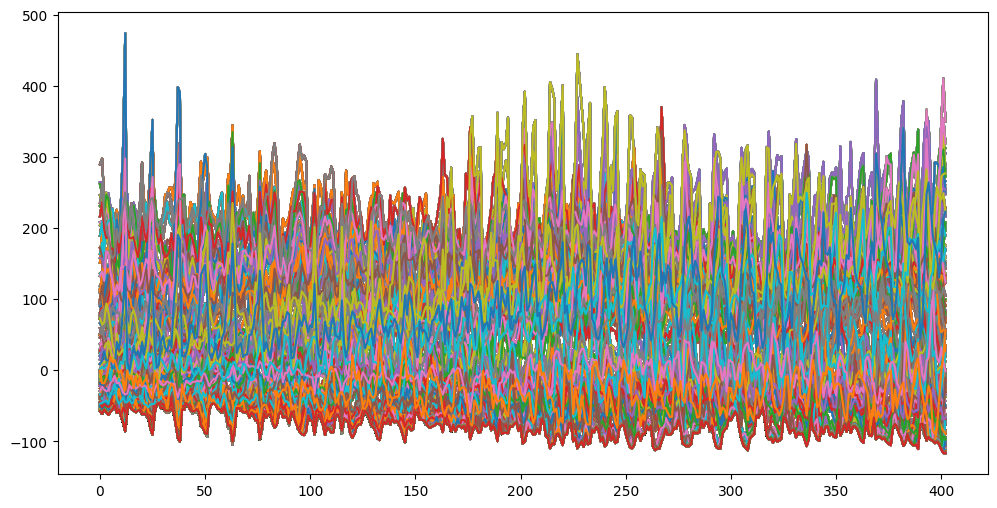

In [63]:
plt.figure(figsize=(12, 6))
for grid in detrended_diff_CHIRPS_all.keys():

    plt.plot(range(len(detrended_diff_TAMSAT_all[grid])), detrended_diff_TAMSAT_all[grid], label="Detrended TAMSAT")


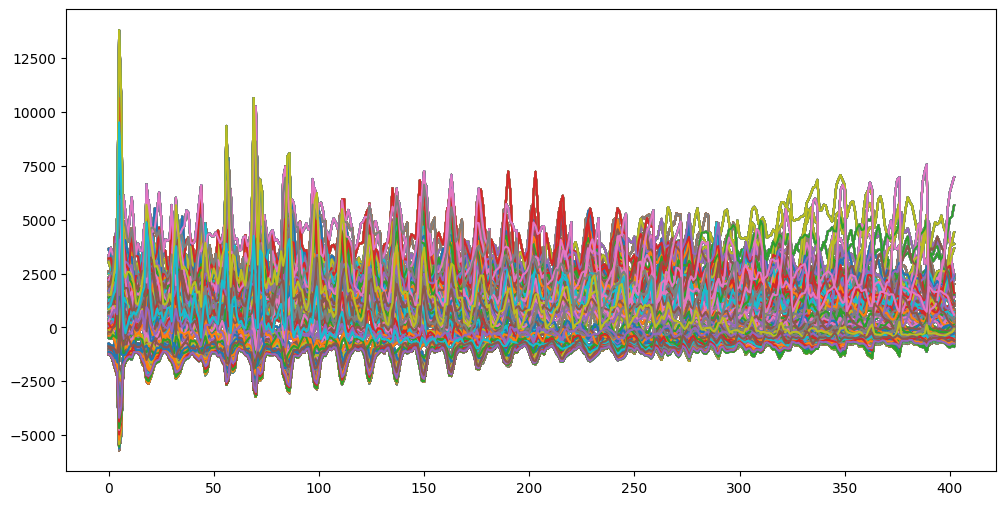

In [64]:
plt.figure(figsize=(12, 6))
for grid in detrended_diff_CHIRPS_all.keys():
    plt.plot(range(len(detrended_diff_ERA5_all[grid])),detrended_diff_ERA5_all[grid], label="Detrended CHIRPS-TAMSAT Diff")